In [145]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import os
import scipy.io.wavfile as wav

from collections import namedtuple
from scipy.fft import rfft, rfftfreq
from scipy.signal import ShortTimeFFT, windows

In [146]:
AUDIO_DIR = "audio/"


# named tuple representing a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])


# create a signal from a file
def signal_from_file(filename):
    # read the audio file
    fs, y = wav.read(filename)

    # normalize the signal
    # signal values are stored as 16-bit integers
    y = y / 2**15

    return Signal(y, fs, os.path.basename(filename))


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, frame_duration):
    frame_len = round(frame_duration * signal.fs)
    total_frames = len(signal.y) // frame_len

    frames = signal.y[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


# plot signal in continuous time
def plot_signal(y, fs, title, ylabel=None, hline=None):
    t = np.arange(len(y)) / fs

    plt.plot(t, y)
    plt.xlabel("Time (s)")
    plt.title(title)

    if ylabel:
        plt.ylabel(ylabel)

    if hline:
        plt.axhline(y=hline, color="r", linestyle="--")
        # add a legend
        plt.legend(["Signal", "Threshold"])

    plt.show()

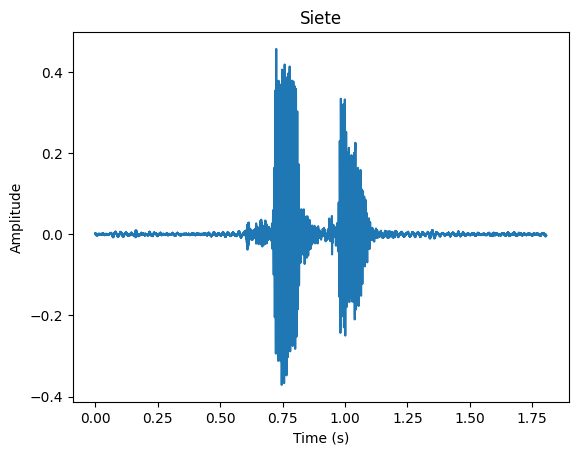

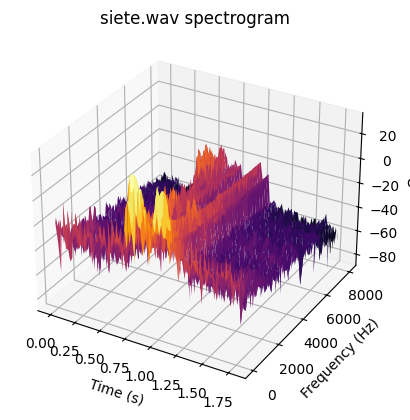

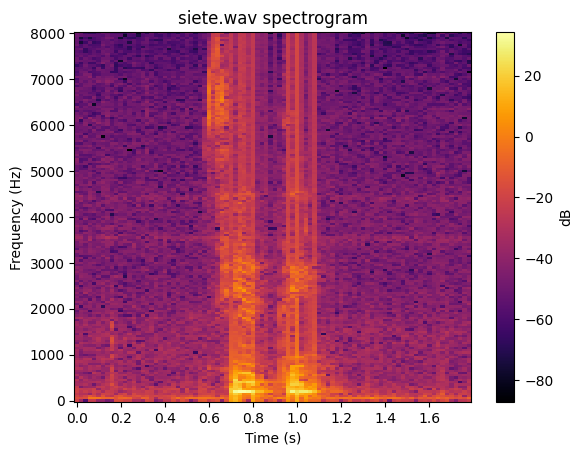

In [147]:
frame_duration = 0.02  # frame duration in seconds

# read the signal from the file
signal = signal_from_file(os.path.join(AUDIO_DIR, "siete.wav"))

# plot the signal
plot_signal(signal.y, signal.fs, "Siete", "Amplitude")

# decompose the signal into non overlapping frames
frames = non_overlapping_frames(signal, frame_duration)

# compute the fft of the frames
frames_fft = abs(rfft(frames, axis=0))

# represent the spectrogram of the signal
frame_len, total_frames = frames.shape

t = np.arange(total_frames) * frame_duration
f = rfftfreq(frame_len, 1 / signal.fs)
T, F = np.meshgrid(t, f)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(T, F, 20 * np.log10(frames_fft), cmap="inferno")
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("dB")
plt.show()

fig, ax = plt.subplots()
pcm = ax.pcolormesh(T, F, 20 * np.log10(frames_fft), cmap="inferno")
fig.colorbar(pcm, ax=ax, label="dB")
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

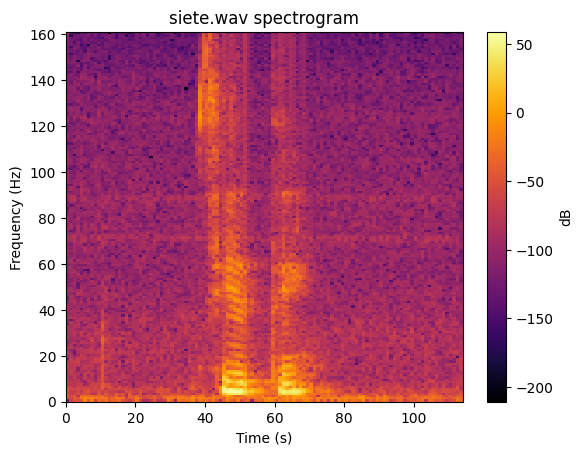

In [148]:
SFT = ShortTimeFFT(win=windows.hamming(frame_len), fs=signal.fs, hop=256)

Sx = SFT.spectrogram(signal.y)
plt.pcolormesh(20 * np.log10(Sx), cmap="inferno")
plt.colorbar(label="dB")
plt.title(f"{signal.file} spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

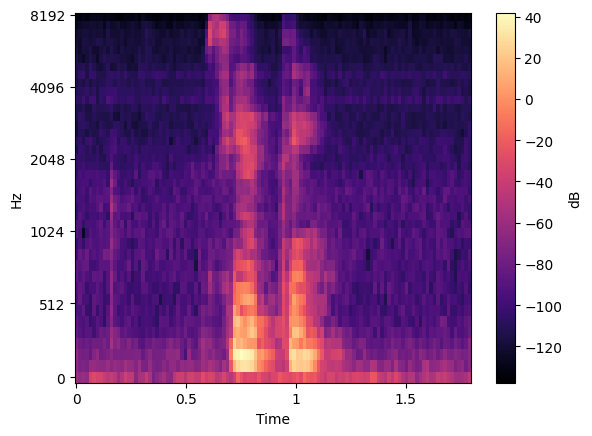

In [149]:
# compute the mel spectrogram
S = lr.feature.melspectrogram(
    y=signal.y,
    sr=signal.fs,
    win_length=512,
    hop_length=256,
    n_mels=40,
)

# display the mel spectrogram in dB
img = lr.display.specshow(
    20 * np.log10(S),
    x_axis="time",
    y_axis="mel",
    sr=signal.fs,
    hop_length=256,
)
plt.colorbar(img, label="dB")

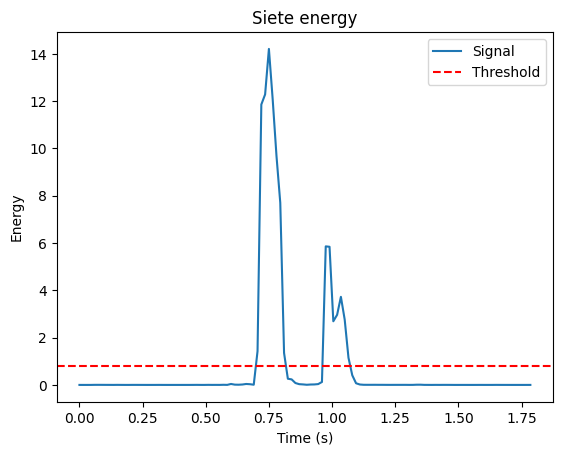

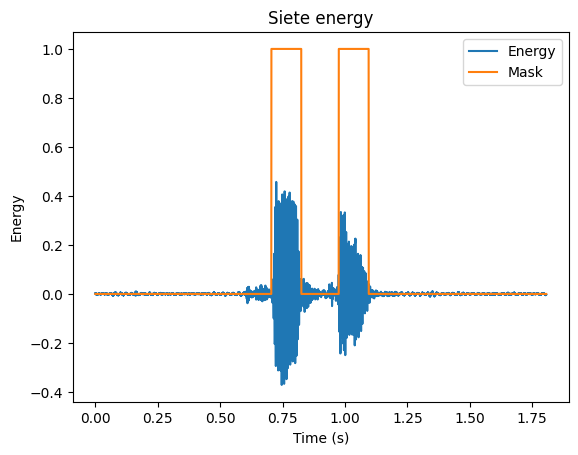

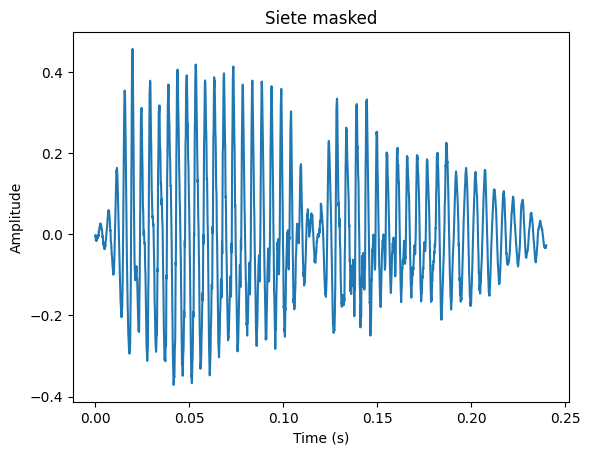

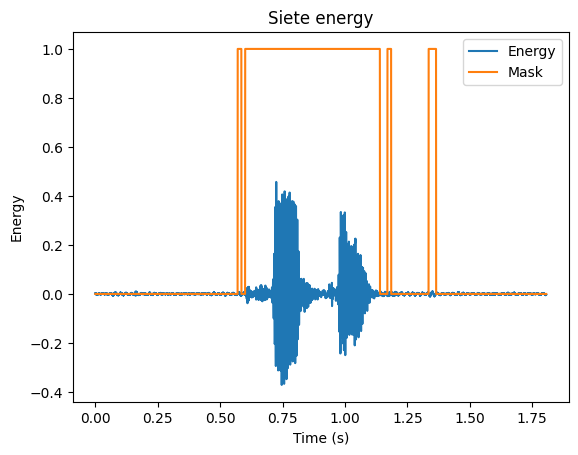

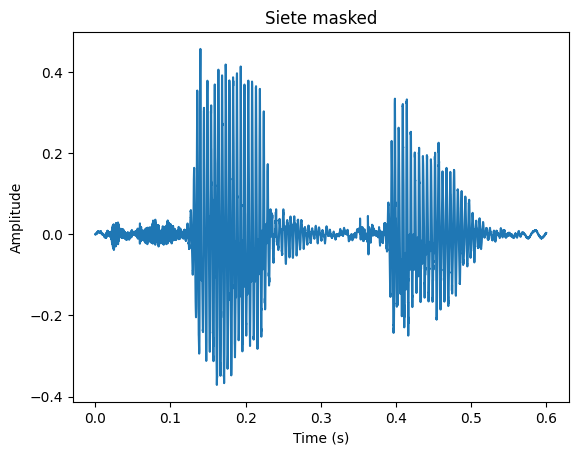

In [150]:
frame_duration = 0.015  # frame duration in seconds

# decompose the signal into non overlapping frames
frames = non_overlapping_frames(signal, frame_duration)

# calculate the energy of the frames and the average energy
energy_frames = np.sum(frames**2, axis=0)
energy_average = np.mean(energy_frames)

# calculate the new sampling frequency
frames_fs = 1 / frame_duration

# plot the energy of the frames with the average energy
plot_signal(
    energy_frames, frames_fs, "Siete energy", ylabel="Energy", hline=energy_average
)


threshold = 0.5 * energy_average  # threshold using the average energy
threshold_2 = 5 * np.mean(
    energy_frames[:27]
)  # threshold using the average energy of the first 27 frames

for threshold in [threshold, threshold_2]:
    # create a mask for the frames that are above the threshold
    mask = (energy_frames > threshold).astype(int)

    # repeat the mask for each frame
    frame_len = len(frames)
    mask = mask.repeat(frame_len)

    # append zeros to the mask to match the signal length
    mask = np.pad(mask, (0, len(signal.y) - len(mask)))

    # plot the mask and the signal in the same plot
    t = np.arange(len(signal.y)) / signal.fs
    fig, ax = plt.subplots()
    ax.plot(t, signal.y, label="Energy")
    ax.plot(t, mask, label="Mask")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Energy")
    ax.set_title("Siete energy")
    ax.legend()
    plt.show()

    # plot only the frames that are above the threshold
    y_masked = signal.y[mask > 0]
    plot_signal(y_masked, signal.fs, "Siete masked", "Amplitude")

    # save the masked signal
    # wav.write("siete_masked.wav", signal.fs, (y_masked * 2**15).astype(np.int16))